In [1]:
import os
os.environ["CONDA_PREFIX"] = "/opt/conda" if os.path.exists("/opt/conda") else '/usr/local'
!pip install -U -q uv

In [2]:
!uv pip install modAL-python torchvision torcheval mlxtend torchsummary scikit-learn-intelex

Resolved 44 packages in 1.11s
Downloaded 15 packages in 1.22s
Installed 15 packages in 74ms
 - contourpy==1.2.0
 - contourpy==1.2.1 (from file:///home/conda/feedstock_root/build_artifacts/contourpy_1712429905637/work)
 + contourpy==1.2.0
 - fonttools==4.47.0
 - fonttools==4.51.0 (from file:///home/conda/feedstock_root/build_artifacts/fonttools_1712344558731/work)
 + fonttools==4.47.0
 - fsspec==2024.2.0
 - fsspec==2024.3.1 (from file:///home/conda/feedstock_root/build_artifacts/fsspec_1710808267764/work)
 + fsspec==2024.2.0
 - markupsafe==2.1.5
 - markupsafe==2.1.3 (from file:///home/conda/feedstock_root/build_artifacts/markupsafe_1695367434228/work)
 + markupsafe==2.1.5
 - matplotlib==3.7.5
 - matplotlib==3.8.4 (from file:///home/conda/feedstock_root/build_artifacts/matplotlib-suite_1712605966339/work)
 + matplotlib==3.7.5
 + modal-python==0.4.2.1
 - pandas==2.1.4
 - pandas==2.2.2
 + pandas==2.2.2
 - pillow==9.5.0
 - pillow==10.3.0 (from file:///home/conda/feedstock_root/build_artifac

# Imports


In [3]:
import random
import warnings
from pathlib import Path
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from mlxtend.plotting import plot_confusion_matrix
from modAL.disagreement import vote_entropy_sampling
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from sklearnex import patch_sklearn
from skorch import NeuralNetClassifier
from torch import nn
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
    multiclass_f1_score,
    multiclass_precision,
    multiclass_recall,
)
from torchsummary import summary
from torchvision import datasets, models
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm

if not os.path.exists("reports_CIFAR10"): os.mkdir("reports_CIFAR10")
patch_sklearn()
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
warnings.filterwarnings("ignore")

torch 2.1.2
torchvision 0.16.2
CUDA available: True
GPU List: 1
Current Device: 0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data

## CIFAR10

In [4]:
CIFAR10_train_data = datasets.CIFAR10(
    root="data_CIFAR10",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)
CIFAR10_test_data = datasets.CIFAR10(
    root="data_CIFAR10",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

x_train, y_train = CIFAR10_train_data.data, np.array(CIFAR10_train_data.targets)
x_test, y_test = CIFAR10_test_data.data, np.array(CIFAR10_test_data.targets)

100%|██████████| 170498071/170498071 [00:10<00:00, 16072984.23it/s]


Extracting data_CIFAR10/cifar-10-python.tar.gz to data_CIFAR10
Files already downloaded and verified


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [7]:
x_train = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2).numpy()
x_test = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2).numpy()

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 3, 32, 32), (50000,), (10000, 3, 32, 32), (10000,))

In [9]:
CIFAR10_class_names = CIFAR10_train_data.classes
CIFAR10_class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
num_classes = len(CIFAR10_class_names)
num_classes

10

In [11]:
class_to_idx_cif = CIFAR10_train_data.class_to_idx
class_to_idx_cif

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

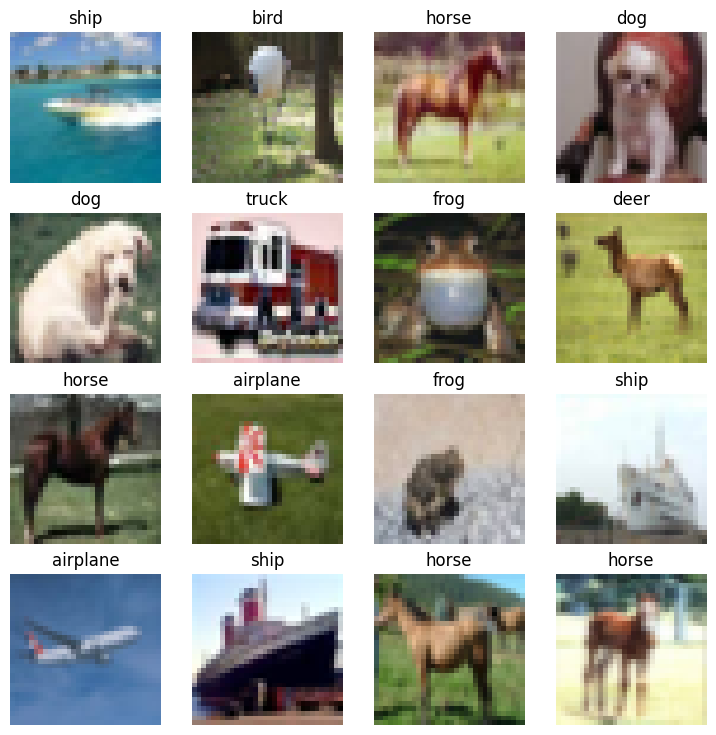

In [12]:
plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_index = torch.randint(1, len(CIFAR10_train_data), size=[1]).item()
    plt.subplot(rows, cols, i)
    image, label = CIFAR10_train_data[random_index]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image, cmap="gray")
    plt.title(CIFAR10_class_names[label])
    plt.axis(False)

plt.savefig("reports_CIFAR10/CIFAR10_images_with_label.png")
plt.show()

## Unlabelling The Dataset


In [13]:
percentage_without_labels = 0.8

num_samples_without_labels = int(len(CIFAR10_train_data) * percentage_without_labels)
num_samples_with_labels = len(CIFAR10_train_data) - num_samples_without_labels

indices_without_labels = np.random.choice(range(len(CIFAR10_train_data)), size=num_samples_without_labels, replace=False)
indices_with_labels = np.array([i for i in range(len(CIFAR10_train_data)) if i not in indices_without_labels])

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

In [14]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

((10000, 3, 32, 32), (10000,), (40000, 3, 32, 32), (40000,))

In [15]:
len(CIFAR10_train_data)

50000

In [16]:
CIFAR10_train_data[1][1]

9

## Creating the DataLoaders


In [17]:
def numpy_to_dataloader(x, y, batch_size=32):
    dataset = torch.utils.data.TensorDataset(torch.tensor(x, dtype=torch.float32), torch.tensor(y))
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
BATCH_SIZE_CIF = 32

In [19]:
CIFAR10_train_data_loader = numpy_to_dataloader(x_initial, y_initial, BATCH_SIZE_CIF)
CIFAR10_test_data_loader = numpy_to_dataloader(x_test, y_test, BATCH_SIZE_CIF)

In [20]:
CIFAR10_train_data_loader, CIFAR10_test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x79acf5608040>,
 <torch.utils.data.dataloader.DataLoader at 0x79ade8741cc0>)

In [21]:
print(f"Length of Training Data loader: {len(CIFAR10_train_data_loader)}, Batches of {CIFAR10_train_data_loader.batch_size}")
print(f"Length of Testing Data loader: {len(CIFAR10_test_data_loader)}, Batches of {CIFAR10_test_data_loader.batch_size}")

Length of Training Data loader: 313, Batches of 32
Length of Testing Data loader: 313, Batches of 32


# Raw Model

## Importing and Using ResNet 50 Architecture


In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [23]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
next(model.parameters()).device

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


device(type='cpu')

In [24]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

## Printing the Architecture and Number of Training Parameters in each Layer


In [25]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [27]:
def display_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")

In [28]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device,
):
    training_loss = []
    training_acc = []
    model.train()

    for batch, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        training_loss.append(loss)
        training_acc.append(multiclass_accuracy(y_pred.argmax(dim=1), y, num_classes=10))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    training_loss = torch.tensor(training_loss).mean()
    training_acc = torch.tensor(training_acc).mean()
    print(f"Training -> Loss: {training_loss:.3f} | Accuracy: {training_acc:.3f}")
    return training_acc, training_loss

In [29]:
def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: nn.Module,
    device: torch.device = device,
):
    testing_acc = []
    testing_loss = []
    testing_f1 = []
    testing_precision = []
    testing_recall = []
    model.eval()

    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = model(x)
            testing_loss.append(loss_fn(y_test_pred, y))
            testing_acc.append(multiclass_accuracy(y_test_pred.argmax(dim=1), y, num_classes=10))
            testing_f1.append(multiclass_f1_score(y_test_pred.argmax(dim=1), y, num_classes=10))
            testing_precision.append(multiclass_precision(y_test_pred.argmax(dim=1), y, num_classes=10))
            testing_recall.append(multiclass_recall(y_test_pred.argmax(dim=1), y, num_classes=10))
            
        testing_loss = torch.tensor(testing_loss).mean()
        testing_acc = torch.tensor(testing_acc).mean()
        testing_f1 = torch.tensor(testing_f1).mean()
        testing_precision = torch.tensor(testing_precision).mean()
        testing_recall = torch.tensor(testing_recall).mean()
        
    print(f"Testing -> Loss: {testing_loss:.3f} | Accuracy: {testing_acc:.3f} | F1 Score: {testing_f1:.3f} | Precision: {testing_precision:.3f} | Recall: {testing_recall:.3f}")
    return testing_acc, testing_loss, testing_f1, testing_precision, testing_recall

## Training


In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_start = timer()
epochs = 2
acc_TRAIN = []
acc_TEST = []
loss_TRAIN = []
loss_TEST = []
precision_result = []
recall_result = []
f1_result = []

for epoch in tqdm(range(epochs)):
    print(f"\nepoch: {epoch+1}\n--------------------------------------")
    ACC_TRAIN = 0
    LOSS_TRAIN = 0
    ACC_TEST = 0
    LOSS_TEST = 0
    F1 = 0
    PRECISION = 0
    RECALL = 0
    ACC_TRAIN, LOSS_TRAIN = train_step(model, CIFAR10_train_data_loader, loss_fn, optimizer, device)
    ACC_TEST, LOSS_TEST, F1, PRECISION, RECALL = test_step(model, CIFAR10_test_data_loader, loss_fn, device)

    acc_TRAIN.append(ACC_TRAIN.detach().cpu().numpy())
    acc_TEST.append(ACC_TEST.detach().cpu().numpy())
    loss_TRAIN.append(LOSS_TRAIN.detach().cpu().numpy())
    loss_TEST.append(LOSS_TEST.detach().cpu().numpy())
    precision_result.append(PRECISION.detach().cpu().numpy())
    recall_result.append(RECALL.detach().cpu().numpy())
    f1_result.append(F1.detach().cpu().numpy())

print("\nTraining is finished!\n")
train_end = timer()
display_train_time(train_start, train_end, device=next(model.parameters()).device)

  0%|          | 0/2 [00:00<?, ?it/s]


epoch: 1
--------------------------------------
Training -> Loss: 2.811 | Accuracy: 0.173
Testing -> Loss: 2.295 | Accuracy: 0.197 | F1 Score: 0.197 | Precision: 0.197 | Recall: 0.197

epoch: 2
--------------------------------------
Training -> Loss: 2.047 | Accuracy: 0.231
Testing -> Loss: 2.415 | Accuracy: 0.247 | F1 Score: 0.247 | Precision: 0.247 | Recall: 0.247

Training is finished!

Train time on device cuda:0: 28.774 seconds


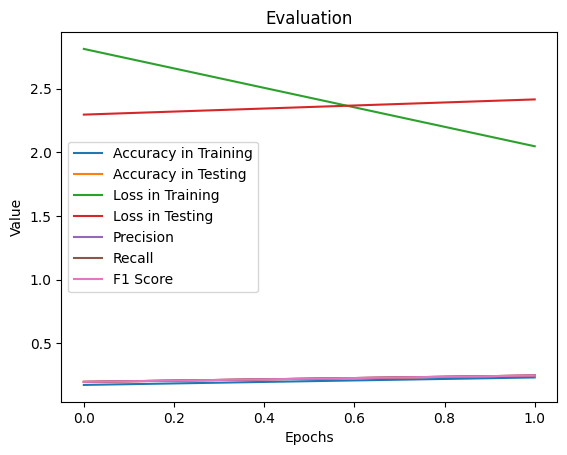

Accuracy in Training: 0.23132987320423126
Accuracy in Testing: 0.24650558829307556
Loss in Training: 2.0467066764831543
Loss in Testing: 2.4145750999450684
Precision: 0.24650558829307556
Recall: 0.24650558829307556
F1 Score: 0.24650558829307556


In [31]:
fig, ax = plt.subplots()

plt.plot(acc_TRAIN, label="Accuracy in Training")
plt.plot(acc_TEST, label="Accuracy in Testing")
plt.plot(loss_TRAIN, label="Loss in Training")
plt.plot(loss_TEST, label="Loss in Testing")
plt.plot(precision_result, label="Precision")
plt.plot(recall_result, label="Recall")
plt.plot(f1_result, label="F1 Score")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Evaluation")

plt.legend()
plt.savefig("reports_CIFAR10/raw_model_evaluations_before_al.png")
plt.show()

print(f"Accuracy in Training: {acc_TRAIN[-1]}")
print(f"Accuracy in Testing: {acc_TEST[-1]}")
print(f"Loss in Training: {loss_TRAIN[-1]}")
print(f"Loss in Testing: {loss_TEST[-1]}")
print(f"Precision: {precision_result[-1]}")
print(f"Recall: {recall_result[-1]}")
print(f"F1 Score: {f1_result[-1]}")

In [32]:
torch.manual_seed(42)

In [33]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    device: torch.device = device,
):
    model.eval()
    loss = 0
    acc = 0
    f1 = 0
    precision = 0
    recall = 0
    y_pred_list = []
    
    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss += loss_fn(y_pred, y)
            y_pred_list.append(y_pred.argmax(dim=1).cpu().numpy())
            acc += multiclass_accuracy(torch.argmax(y_pred, dim=1), y, num_classes=10)
            f1 += multiclass_f1_score(y_pred.argmax(dim=1), y, num_classes=10)
            precision += multiclass_precision(y_pred.argmax(dim=1), y, num_classes=10)
            recall += multiclass_recall(y_pred.argmax(dim=1), y, num_classes=10)
            
        loss /= len(data_loader)
        acc /= len(data_loader)
        f1 /= len(data_loader)
        precision /= len(data_loader)
        recall /= len(data_loader)
        y_pred_list = np.concatenate(y_pred_list)
        
    return {
        "Model Name": model.__class__.__name__,
        "Model Loss": loss.item(),
        "Model Accuracy": acc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
    }, y_pred_list

In [34]:
model_results, y_pred = eval_model(model, CIFAR10_test_data_loader, loss_fn)

  0%|          | 0/313 [00:00<?, ?it/s]

In [35]:
model_results

{'Model Name': 'ResNet',
 'Model Loss': 2.4146153926849365,
 'Model Accuracy': tensor(0.2467, device='cuda:0'),
 'F1 Score': tensor(0.2467, device='cuda:0'),
 'Precision': tensor(0.2467, device='cuda:0'),
 'Recall': tensor(0.2467, device='cuda:0')}

In [36]:
y_pred.shape

(10000,)

## Evaluating Model Visually


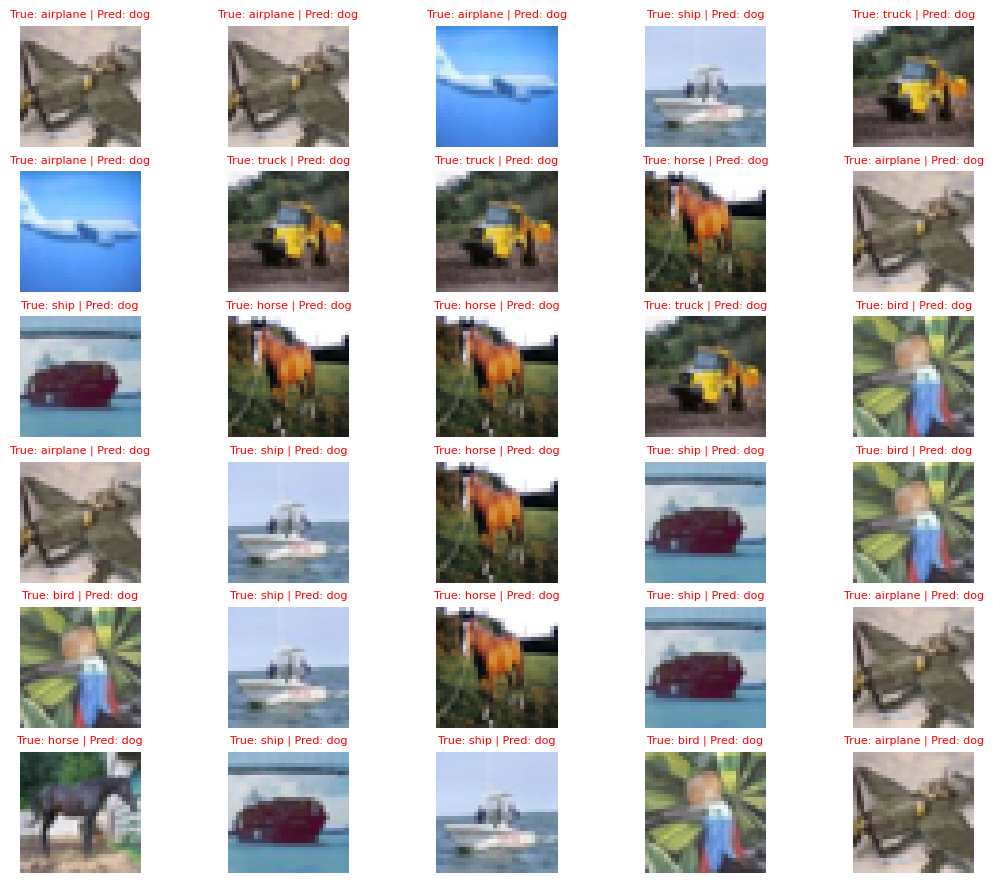

In [37]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(CIFAR10_test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

rows = 6
cols = 5

plt.figure(figsize=(13, 11))

model.eval()
with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)
        random_index = torch.randint(1, 9, size=[1]).item()
        image, label = test_samples[random_index], test_labels[random_index]
        pred_label = model(image.unsqueeze(0).to(device)).argmax()
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image, cmap="gray")
        
        if pred_label == label:
            plt.title(f"True: {CIFAR10_class_names[label]} | Pred: {CIFAR10_class_names[pred_label]}", c="g", fontsize=9)
        else:
            plt.title(f"True: {CIFAR10_class_names[label]} | Pred: {CIFAR10_class_names[pred_label]}", c="r", fontsize=8)
        plt.axis(False)
        
plt.savefig("reports_CIFAR10/raw_model_predictions_before_al.png")

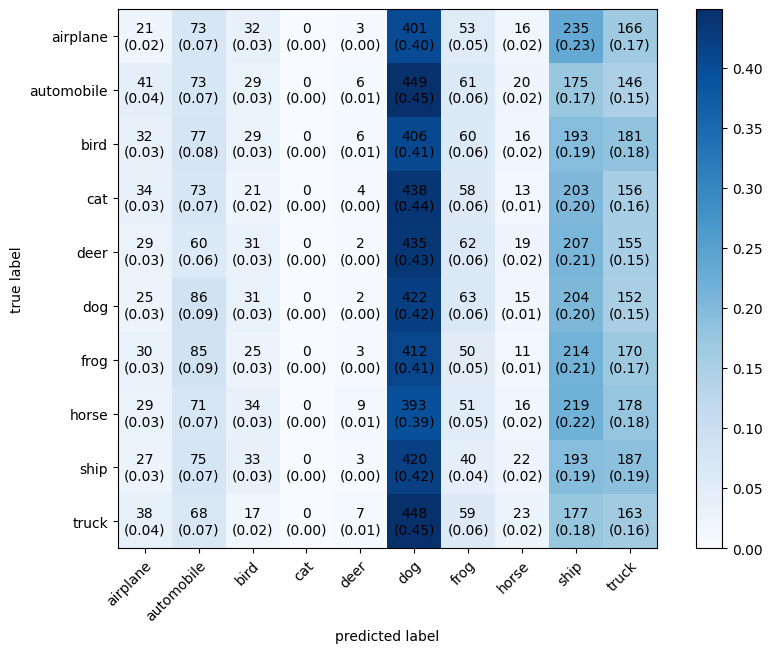

In [38]:
confusion_matrix = multiclass_confusion_matrix(torch.tensor(y_pred), torch.tensor(CIFAR10_test_data.targets), num_classes=num_classes)
plot_confusion_matrix(
    conf_mat=confusion_matrix.numpy(),
    class_names=CIFAR10_class_names,
    figsize=(10, 7),
    show_absolute=True,
    show_normed=True,
    colorbar=True,
)

plt.savefig("reports_CIFAR10/raw_model_confusion_matrix_before_al.png")

## Saving the Model


In [39]:
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "base_model.pth"
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/base_model.pth


## Load the Model


In [40]:
trained_model = models.resnet50().to(device)
trained_model.fc = nn.Linear(model.fc.in_features, num_classes)
trained_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
trained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
summary(trained_model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,096
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,384
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,384
      BatchNorm2d-14            [-1, 25

# Active Learning


In [42]:
cycles = 100

In [43]:
trained_model = NeuralNetClassifier(
    trained_model,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    verbose=0,
    device=device,
)

In [44]:
trained_model.initialize()

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=

In [45]:
loss_fn = nn.MSELoss()

In [46]:
def active_learning(pool_x, pool_y, method, model_estimator, num_classes, class_names):
    learner = None
    acc_train = []
    acc_test = []
    precision_result = []
    recall_result = []
    f1_result = []
    loss = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=uncertainty_sampling)
    elif method == "margin_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=margin_sampling)
    elif method == "entropy_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=entropy_sampling)
    elif method == "random_sampling":
        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
            query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
            X_query = pool_x[query_idx]
            return query_idx, X_query

        learner = ActiveLearner(estimator=model_estimator, query_strategy=random_sampling)
    elif method == "query_by_committee":
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):
            Learner = ActiveLearner(estimator=model_estimator)
            learner_list.append(Learner)
        learner = Committee(learner_list=learner_list, query_strategy=vote_entropy_sampling)
    else:
        print("Invalid Input")
        
    print(f"Starting Active Learning with {method.replace('_', ' ')} method")

    for cycle in range(cycles):
        print(f"Cycle: {cycle + 1}")
        query_idx, _ = learner.query(pool_x, n_instances=100)
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)

        model_accuracy = learner.score(x_train, y_train)
        acc_train.append(model_accuracy)
        y_pred = learner.predict(x_test)

        acc_test.append(
            multiclass_accuracy(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        precision_result.append(
            multiclass_precision(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        recall_result.append(
            multiclass_recall(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        f1_result.append(
            multiclass_f1_score(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        loss.append(
            loss_fn(
                torch.tensor(y_pred, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
            )
        )

        print(f"\tTraining Accuracy: {acc_train[-1]:.3f}")
        print(f"\tTesting Accuracy: {acc_test[-1]:.3f}")
        print(f"\tPrecision: {precision_result[-1]:.3f}")
        print(f"\tRecall: {recall_result[-1]:.3f}")
        print(f"\tF1 Score: {f1_result[-1]:.3f}")
        print(f"\tLoss: {loss[-1]:.3f}")
        
        try:
            slope = (loss[-1] - loss[-10]) / 9
            print("\tSlop after 10 Epochs", slope)
            if slope >= 0.01:
                break
        except Exception:
            continue

    print(f"Active Learning with {method} method is finished")
    confusion_matrix = multiclass_confusion_matrix(
        torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
    )
    plot_confusion_matrix(
        conf_mat=confusion_matrix.numpy(),
        class_names=class_names,
        figsize=(10, 7),
        show_absolute=True,
        show_normed=True,
        colorbar=True,
    )

    plt.savefig(f"reports_CIFAR10/{method}_confusion_matrix_after_al.png")
    return {
        "Train Accuracy": acc_train,
        "Test Accuracy": acc_test,
        "Precision": precision_result,
        "Recall": recall_result,
        "F1 Score": f1_result,
        "Loss": loss
    }

## Random Sampling

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


Starting Active Learning with random sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.167
	Testing Accuracy: 0.170
	Precision: 0.170
	Recall: 0.170
	F1 Score: 0.170
	Loss: 15.857
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.192
	Testing Accuracy: 0.191
	Precision: 0.191
	Recall: 0.191
	F1 Score: 0.191
	Loss: 18.017
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.246
	Testing Accuracy: 0.248
	Precision: 0.248
	Recall: 0.248
	F1 Score: 0.248
	Loss: 12.856
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.283
	Testing Accuracy: 0.280
	Precision: 0.280
	Recall: 0.280
	F1 Score: 0.280
	Loss: 12.922
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.291
	Testing Accuracy: 0.288
	Precision: 0.288
	Recall: 0.288
	F1 Score: 0.288
	Loss: 13.500
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.307
	Testing Accuracy: 0.305
	Precision: 0.305
	Recall: 0.305
	F1 Score: 0.305
	Loss: 12.349
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.325
	Testing Accuracy: 0.324
	Precision: 0.324
	Recall: 0.324
	F1 Score: 0.324
	Loss: 13.286
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.331
	Testing Accuracy: 0.321
	Precision: 0.321
	Recall: 0.321
	F1 Score: 0.321
	Loss: 13.212
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.324
	Testing Accuracy: 0.315
	Precision: 0.315
	Recall: 0.315
	F1 Score: 0.315
	Loss: 13.458
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.336
	Testing Accuracy: 0.328
	Precision: 0.328
	Recall: 0.328
	F1 Score: 0.328
	Loss: 12.732
	Slop after 10 Epochs tensor(-0.3472)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.325
	Testing Accuracy: 0.316
	Precision: 0.316
	Recall: 0.316
	F1 Score: 0.316
	Loss: 12.829
	Slop after 10 Epochs tensor(-0.5764)
Cycle: 12
	Training Accuracy: 0.366
	Testing Accuracy: 0.352
	Precision: 0.352
	Recall: 0.352
	F1 Score: 0.352
	Loss: 13.107
	Slop after 10 Epochs tensor(0.0280)
Active Learning with random_sampling method is finished


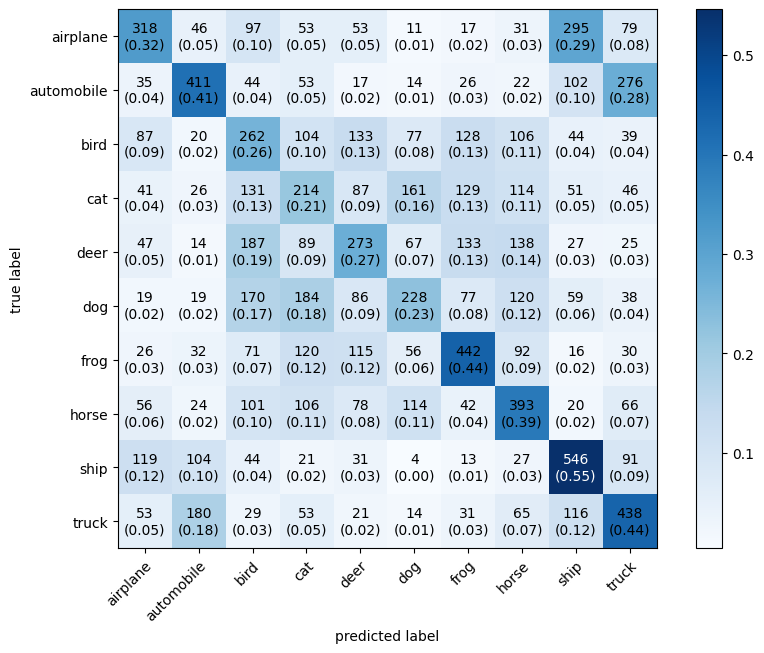

In [47]:
results_random_sampling = active_learning(x_pool, y_pool, "random_sampling", trained_model, 10, CIFAR10_class_names)

## Uncertainty Sampling

Starting Active Learning with uncertainty sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.228
	Testing Accuracy: 0.225
	Precision: 0.225
	Recall: 0.225
	F1 Score: 0.225
	Loss: 12.882
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.282
	Testing Accuracy: 0.279
	Precision: 0.279
	Recall: 0.279
	F1 Score: 0.279
	Loss: 13.600
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.300
	Testing Accuracy: 0.295
	Precision: 0.295
	Recall: 0.295
	F1 Score: 0.295
	Loss: 13.744
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.307
	Testing Accuracy: 0.299
	Precision: 0.299
	Recall: 0.299
	F1 Score: 0.299
	Loss: 13.371
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.327
	Testing Accuracy: 0.320
	Precision: 0.320
	Recall: 0.320
	F1 Score: 0.320
	Loss: 13.797
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.342
	Testing Accuracy: 0.337
	Precision: 0.337
	Recall: 0.337
	F1 Score: 0.337
	Loss: 13.237
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.344
	Testing Accuracy: 0.334
	Precision: 0.334
	Recall: 0.334
	F1 Score: 0.334
	Loss: 13.454
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.353
	Testing Accuracy: 0.347
	Precision: 0.347
	Recall: 0.347
	F1 Score: 0.347
	Loss: 13.382
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.358
	Testing Accuracy: 0.343
	Precision: 0.343
	Recall: 0.343
	F1 Score: 0.343
	Loss: 13.566
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.342
	Testing Accuracy: 0.332
	Precision: 0.332
	Recall: 0.332
	F1 Score: 0.332
	Loss: 11.569
	Slop after 10 Epochs tensor(-0.1458)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.383
	Testing Accuracy: 0.367
	Precision: 0.367
	Recall: 0.367
	F1 Score: 0.367
	Loss: 12.651
	Slop after 10 Epochs tensor(-0.1055)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.375
	Testing Accuracy: 0.356
	Precision: 0.356
	Recall: 0.356
	F1 Score: 0.356
	Loss: 13.541
	Slop after 10 Epochs tensor(-0.0226)
Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.390
	Testing Accuracy: 0.371
	Precision: 0.371
	Recall: 0.371
	F1 Score: 0.371
	Loss: 12.967
	Slop after 10 Epochs tensor(-0.0448)
Cycle: 14


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.403
	Testing Accuracy: 0.386
	Precision: 0.386
	Recall: 0.386
	F1 Score: 0.386
	Loss: 12.337
	Slop after 10 Epochs tensor(-0.1623)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.400
	Testing Accuracy: 0.382
	Precision: 0.382
	Recall: 0.382
	F1 Score: 0.382
	Loss: 12.268
	Slop after 10 Epochs tensor(-0.1077)
Cycle: 16


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.422
	Testing Accuracy: 0.399
	Precision: 0.399
	Recall: 0.399
	F1 Score: 0.399
	Loss: 12.109
	Slop after 10 Epochs tensor(-0.1495)
Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.422
	Testing Accuracy: 0.398
	Precision: 0.398
	Recall: 0.398
	F1 Score: 0.398
	Loss: 12.417
	Slop after 10 Epochs tensor(-0.1072)
Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.434
	Testing Accuracy: 0.411
	Precision: 0.411
	Recall: 0.411
	F1 Score: 0.411
	Loss: 12.009
	Slop after 10 Epochs tensor(-0.1729)
Cycle: 19


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.433
	Testing Accuracy: 0.407
	Precision: 0.407
	Recall: 0.407
	F1 Score: 0.407
	Loss: 11.988
	Slop after 10 Epochs tensor(0.0466)
Active Learning with uncertainty_sampling method is finished


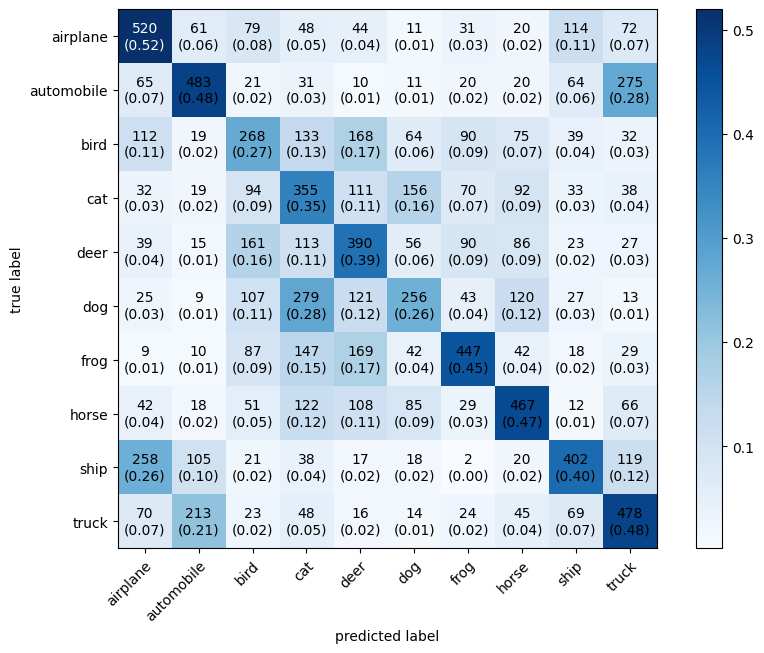

In [48]:
results_uncertainty_sampling = active_learning(x_pool, y_pool, "uncertainty_sampling", trained_model, 10, CIFAR10_class_names)

## Margin Sampling

Starting Active Learning with margin sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.318
	Testing Accuracy: 0.306
	Precision: 0.306
	Recall: 0.306
	F1 Score: 0.306
	Loss: 12.930
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.328
	Testing Accuracy: 0.330
	Precision: 0.330
	Recall: 0.330
	F1 Score: 0.330
	Loss: 14.878
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.335
	Testing Accuracy: 0.324
	Precision: 0.324
	Recall: 0.324
	F1 Score: 0.324
	Loss: 14.582
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.364
	Testing Accuracy: 0.352
	Precision: 0.352
	Recall: 0.352
	F1 Score: 0.352
	Loss: 13.343
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.383
	Testing Accuracy: 0.379
	Precision: 0.379
	Recall: 0.379
	F1 Score: 0.379
	Loss: 13.351
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.393
	Testing Accuracy: 0.384
	Precision: 0.384
	Recall: 0.384
	F1 Score: 0.384
	Loss: 12.310
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.387
	Testing Accuracy: 0.378
	Precision: 0.378
	Recall: 0.378
	F1 Score: 0.378
	Loss: 12.941
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.407
	Testing Accuracy: 0.395
	Precision: 0.395
	Recall: 0.395
	F1 Score: 0.395
	Loss: 12.452
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.403
	Testing Accuracy: 0.399
	Precision: 0.399
	Recall: 0.399
	F1 Score: 0.399
	Loss: 11.920
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.419
	Testing Accuracy: 0.409
	Precision: 0.409
	Recall: 0.409
	F1 Score: 0.409
	Loss: 11.943
	Slop after 10 Epochs tensor(-0.1097)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.405
	Testing Accuracy: 0.389
	Precision: 0.389
	Recall: 0.389
	F1 Score: 0.389
	Loss: 12.306
	Slop after 10 Epochs tensor(-0.2858)
Cycle: 12


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.420
	Testing Accuracy: 0.405
	Precision: 0.405
	Recall: 0.405
	F1 Score: 0.405
	Loss: 12.311
	Slop after 10 Epochs tensor(-0.2524)
Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.418
	Testing Accuracy: 0.399
	Precision: 0.399
	Recall: 0.399
	F1 Score: 0.399
	Loss: 12.094
	Slop after 10 Epochs tensor(-0.1388)
Cycle: 14


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.426
	Testing Accuracy: 0.406
	Precision: 0.406
	Recall: 0.406
	F1 Score: 0.406
	Loss: 11.999
	Slop after 10 Epochs tensor(-0.1501)
Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.412
	Testing Accuracy: 0.391
	Precision: 0.391
	Recall: 0.391
	F1 Score: 0.391
	Loss: 12.600
	Slop after 10 Epochs tensor(0.0322)
Active Learning with margin_sampling method is finished


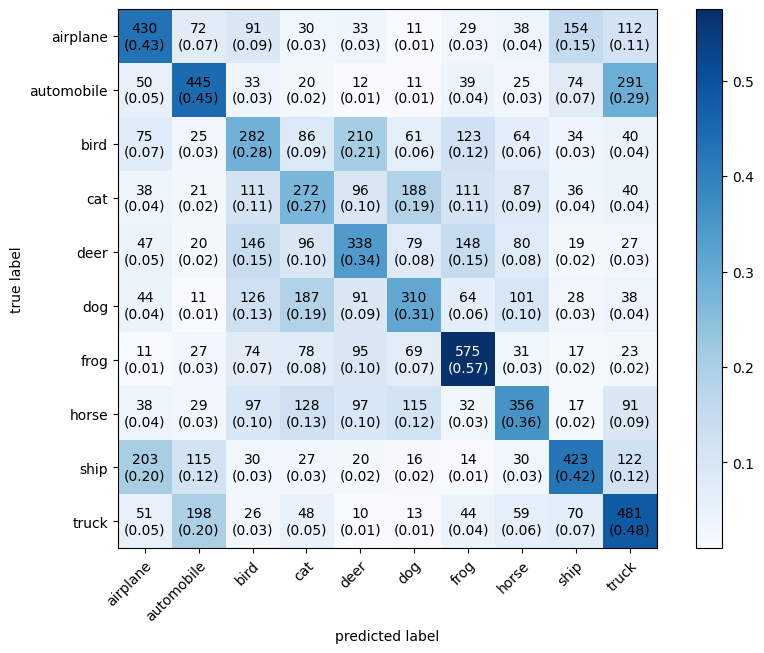

In [49]:
results_margin_sampling = active_learning(x_pool, y_pool, "margin_sampling", trained_model, 10, CIFAR10_class_names)

## Entropy Sampling

Starting Active Learning with entropy sampling method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.352
	Testing Accuracy: 0.340
	Precision: 0.340
	Recall: 0.340
	F1 Score: 0.340
	Loss: 13.038
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.349
	Testing Accuracy: 0.335
	Precision: 0.335
	Recall: 0.335
	F1 Score: 0.335
	Loss: 12.223
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.361
	Testing Accuracy: 0.349
	Precision: 0.349
	Recall: 0.349
	F1 Score: 0.349
	Loss: 12.943
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.345
	Testing Accuracy: 0.330
	Precision: 0.330
	Recall: 0.330
	F1 Score: 0.330
	Loss: 13.820
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.345
	Testing Accuracy: 0.329
	Precision: 0.329
	Recall: 0.329
	F1 Score: 0.329
	Loss: 13.076
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.361
	Testing Accuracy: 0.345
	Precision: 0.345
	Recall: 0.345
	F1 Score: 0.345
	Loss: 13.092
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.372
	Testing Accuracy: 0.352
	Precision: 0.352
	Recall: 0.352
	F1 Score: 0.352
	Loss: 12.907
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.374
	Testing Accuracy: 0.344
	Precision: 0.344
	Recall: 0.344
	F1 Score: 0.344
	Loss: 13.037
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.371
	Testing Accuracy: 0.349
	Precision: 0.349
	Recall: 0.349
	F1 Score: 0.349
	Loss: 13.231
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.391
	Testing Accuracy: 0.355
	Precision: 0.355
	Recall: 0.355
	F1 Score: 0.355
	Loss: 12.876
	Slop after 10 Epochs tensor(-0.0181)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.398
	Testing Accuracy: 0.374
	Precision: 0.374
	Recall: 0.374
	F1 Score: 0.374
	Loss: 13.087
	Slop after 10 Epochs tensor(0.0961)
Active Learning with entropy_sampling method is finished


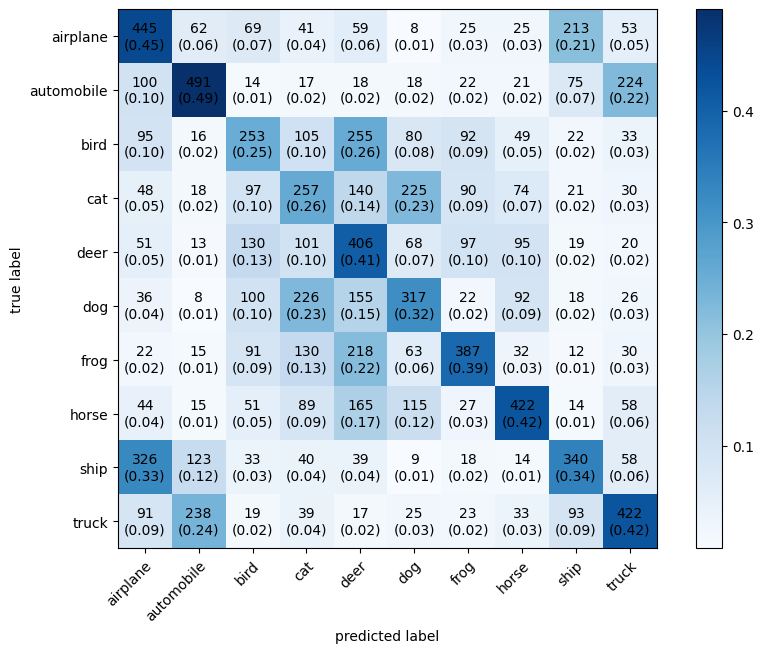

In [50]:
results_entropy_sampling = active_learning(x_pool, y_pool, "entropy_sampling", trained_model, 10, CIFAR10_class_names)

## Query by Committee

Starting Active Learning with query by committee method
Cycle: 1


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.310
	Testing Accuracy: 0.300
	Precision: 0.300
	Recall: 0.300
	F1 Score: 0.300
	Loss: 14.264
Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.325
	Testing Accuracy: 0.317
	Precision: 0.317
	Recall: 0.317
	F1 Score: 0.317
	Loss: 12.377
Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.316
	Testing Accuracy: 0.308
	Precision: 0.308
	Recall: 0.308
	F1 Score: 0.308
	Loss: 12.483
Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.346
	Testing Accuracy: 0.328
	Precision: 0.328
	Recall: 0.328
	F1 Score: 0.328
	Loss: 12.865
Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.331
	Testing Accuracy: 0.325
	Precision: 0.325
	Recall: 0.325
	F1 Score: 0.325
	Loss: 12.754
Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.337
	Testing Accuracy: 0.324
	Precision: 0.324
	Recall: 0.324
	F1 Score: 0.324
	Loss: 13.282
Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.336
	Testing Accuracy: 0.328
	Precision: 0.328
	Recall: 0.328
	F1 Score: 0.328
	Loss: 13.226
Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.359
	Testing Accuracy: 0.351
	Precision: 0.351
	Recall: 0.351
	F1 Score: 0.351
	Loss: 13.548
Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.357
	Testing Accuracy: 0.347
	Precision: 0.347
	Recall: 0.347
	F1 Score: 0.347
	Loss: 12.575
Cycle: 10


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.360
	Testing Accuracy: 0.349
	Precision: 0.349
	Recall: 0.349
	F1 Score: 0.349
	Loss: 12.305
	Slop after 10 Epochs tensor(-0.2176)
Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


	Training Accuracy: 0.379
	Testing Accuracy: 0.361
	Precision: 0.361
	Recall: 0.361
	F1 Score: 0.361
	Loss: 12.710
	Slop after 10 Epochs tensor(0.0370)
Active Learning with query_by_committee method is finished


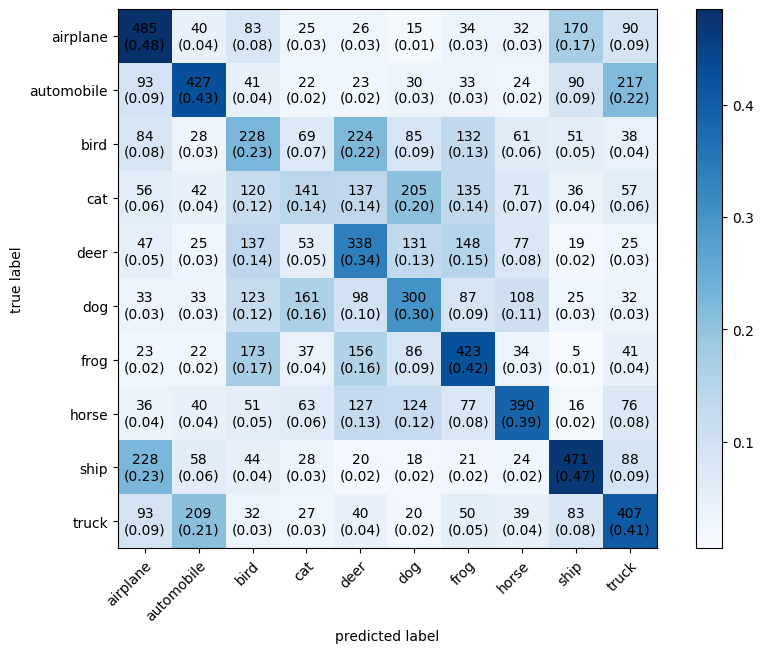

In [51]:
results_committee_sampling = active_learning(x_pool, y_pool, "query_by_committee", trained_model, 10, CIFAR10_class_names)

# Plot All Metrics


## Accuracy


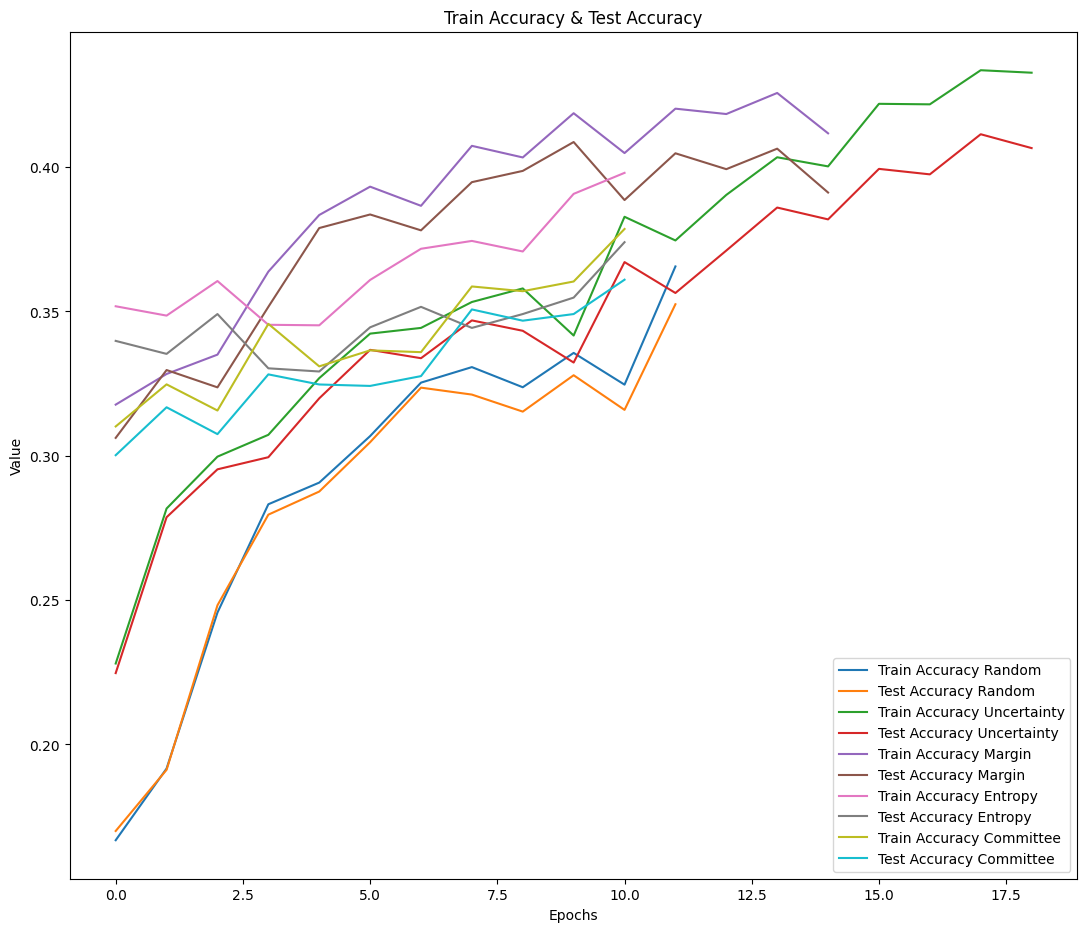

Train Accuracy Random: 0.3656
Test Accuracy Random: 0.35249999165534973
Train Accuracy Uncertainty: 0.43272
Test Accuracy Uncertainty: 0.4065999984741211
Train Accuracy Margin: 0.41172
Test Accuracy Margin: 0.3912000060081482
Train Accuracy Entropy: 0.39802
Test Accuracy Entropy: 0.37400001287460327
Train Accuracy Committee: 0.37858
Test Accuracy Committee: 0.3610000014305115


In [52]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Train Accuracy"], label="Train Accuracy Random")
plt.plot(results_random_sampling["Test Accuracy"], label="Test Accuracy Random")
plt.plot(results_uncertainty_sampling["Train Accuracy"], label="Train Accuracy Uncertainty")
plt.plot(results_uncertainty_sampling["Test Accuracy"], label="Test Accuracy Uncertainty")
plt.plot(results_margin_sampling["Train Accuracy"], label="Train Accuracy Margin")
plt.plot(results_margin_sampling["Test Accuracy"], label="Test Accuracy Margin")
plt.plot(results_entropy_sampling["Train Accuracy"], label="Train Accuracy Entropy")
plt.plot(results_entropy_sampling["Test Accuracy"], label="Test Accuracy Entropy")
plt.plot(results_committee_sampling["Train Accuracy"], label="Train Accuracy Committee")
plt.plot(results_committee_sampling["Test Accuracy"], label="Test Accuracy Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Train Accuracy & Test Accuracy")
plt.legend()
plt.savefig("reports_CIFAR10/model_after_al_accuracy.png")
plt.show()

print(f"Train Accuracy Random: {results_random_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Random: {results_random_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Uncertainty: {results_uncertainty_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Uncertainty: {results_uncertainty_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Margin: {results_margin_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Margin: {results_margin_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Entropy: {results_entropy_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Entropy: {results_entropy_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Committee: {results_committee_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Committee: {results_committee_sampling['Test Accuracy'][-1]}")

## Loss

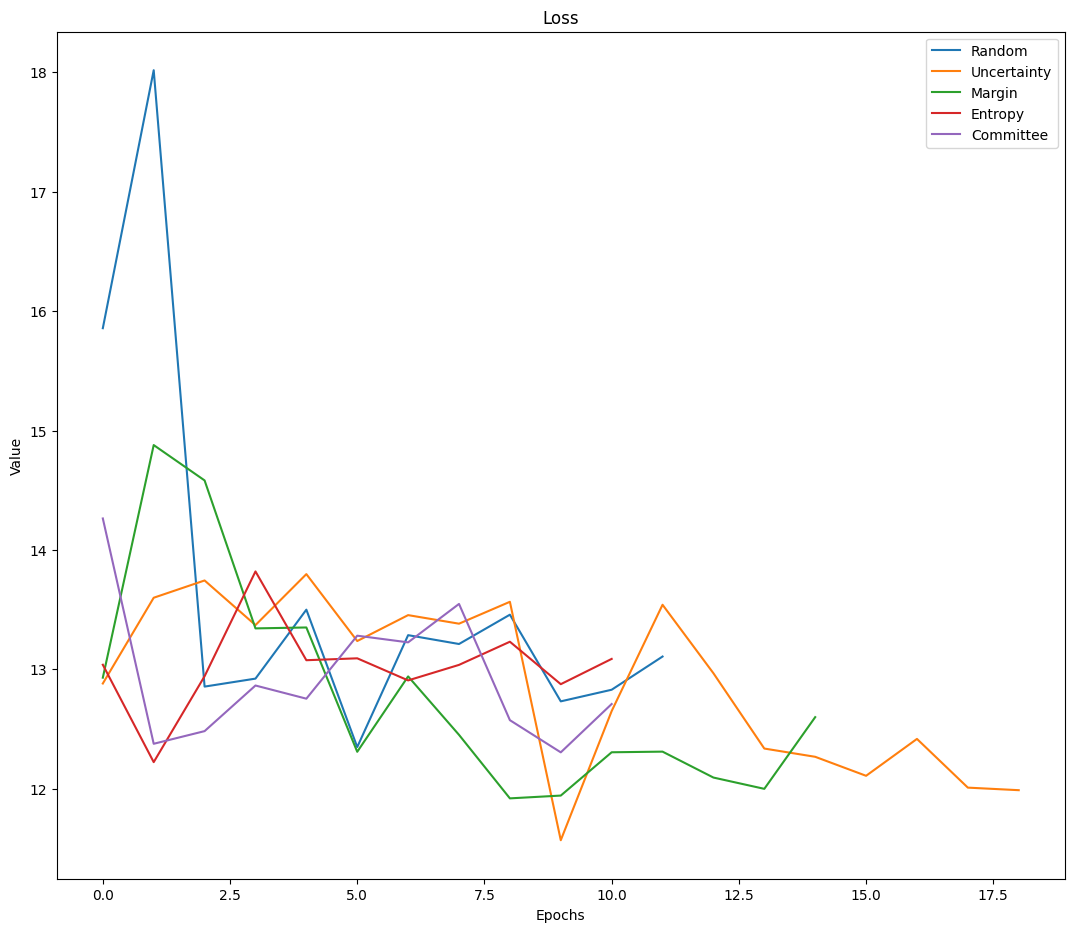

Random: 13.1072998046875
Uncertainty: 11.988100051879883
Margin: 12.599800109863281
Entropy: 13.087499618530273
Committee: 12.709699630737305


In [53]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Loss"], label="Random")
plt.plot(results_uncertainty_sampling["Loss"], label="Uncertainty")
plt.plot(results_margin_sampling["Loss"], label="Margin")
plt.plot(results_entropy_sampling["Loss"], label="Entropy")
plt.plot(results_committee_sampling["Loss"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Loss")
plt.legend()
plt.savefig("reports_CIFAR10/model_after_al_loss.png")
plt.show()

print(f"Random: {results_random_sampling['Loss'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Loss'][-1]}")
print(f"Margin: {results_margin_sampling['Loss'][-1]}")
print(f"Entropy: {results_entropy_sampling['Loss'][-1]}")
print(f"Committee: {results_committee_sampling['Loss'][-1]}")

## Precision


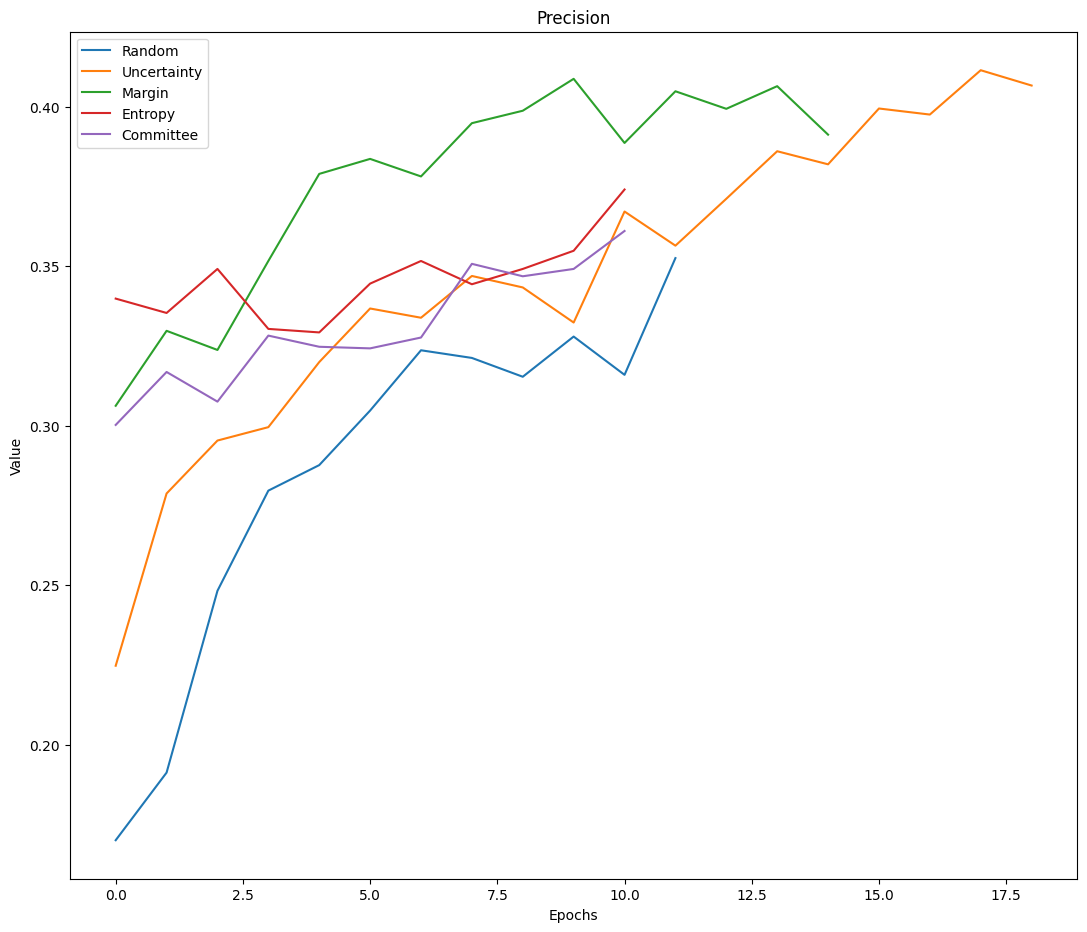

Random: 0.35249999165534973
Uncertainty: 0.4065999984741211
Margin: 0.3912000060081482
Entropy: 0.37400001287460327
Committee: 0.3610000014305115


In [54]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Precision"], label="Random")
plt.plot(results_uncertainty_sampling["Precision"], label="Uncertainty")
plt.plot(results_margin_sampling["Precision"], label="Margin")
plt.plot(results_entropy_sampling["Precision"], label="Entropy")
plt.plot(results_committee_sampling["Precision"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Precision")
plt.legend()
plt.savefig("reports_CIFAR10/model_after_al_precision.png")
plt.show()

print(f"Random: {results_random_sampling['Precision'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Precision'][-1]}")
print(f"Margin: {results_margin_sampling['Precision'][-1]}")
print(f"Entropy: {results_entropy_sampling['Precision'][-1]}")
print(f"Committee: {results_committee_sampling['Precision'][-1]}")

## Recall


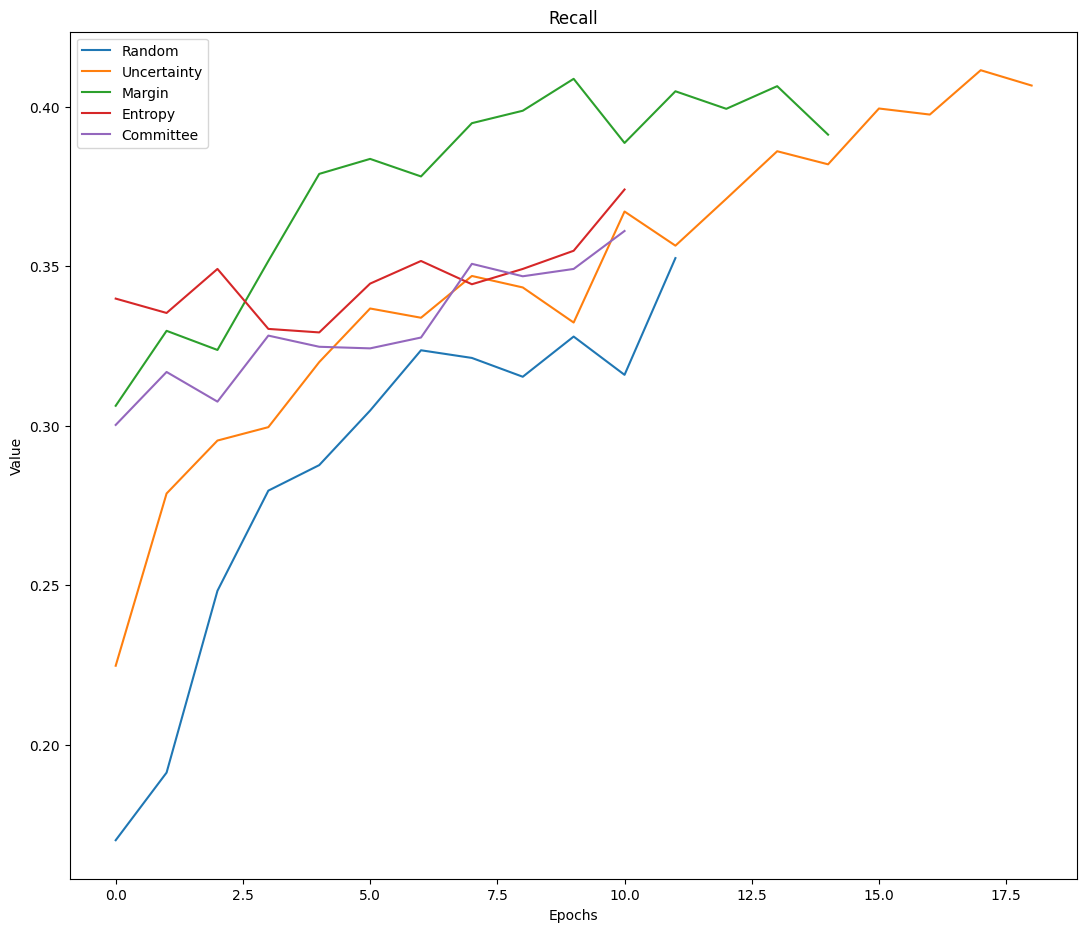

Random: 0.35249999165534973
Uncertainty: 0.4065999984741211
Margin: 0.3912000060081482
Entropy: 0.37400001287460327
Committee: 0.3610000014305115


In [55]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Recall"], label="Random")
plt.plot(results_uncertainty_sampling["Recall"], label="Uncertainty")
plt.plot(results_margin_sampling["Recall"], label="Margin")
plt.plot(results_entropy_sampling["Recall"], label="Entropy")
plt.plot(results_committee_sampling["Recall"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Recall")
plt.legend()
plt.savefig("reports_CIFAR10/model_after_al_recall.png")
plt.show()

print(f"Random: {results_random_sampling['Recall'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Recall'][-1]}")
print(f"Margin: {results_margin_sampling['Recall'][-1]}")
print(f"Entropy: {results_entropy_sampling['Recall'][-1]}")
print(f"Committee: {results_committee_sampling['Recall'][-1]}")

## F1 Score


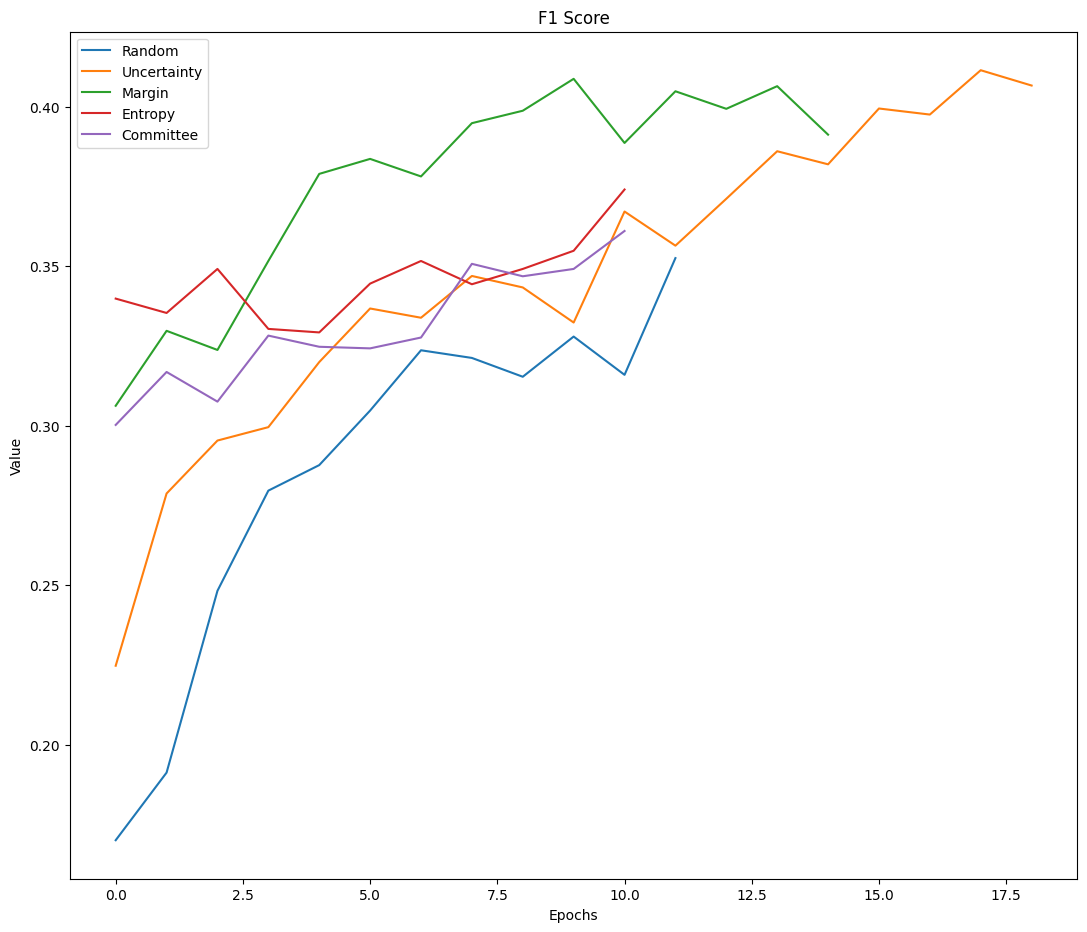

Random: 0.35249999165534973
Uncertainty: 0.4065999984741211
Margin: 0.3912000060081482
Entropy: 0.37400001287460327
Committee: 0.3610000014305115


In [56]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["F1 Score"], label="Random")
plt.plot(results_uncertainty_sampling["F1 Score"], label="Uncertainty")
plt.plot(results_margin_sampling["F1 Score"], label="Margin")
plt.plot(results_entropy_sampling["F1 Score"], label="Entropy")
plt.plot(results_committee_sampling["F1 Score"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("F1 Score")
plt.legend()
plt.savefig("reports_CIFAR10/model_after_al_f1_score.png")
plt.show()

print(f"Random: {results_random_sampling['F1 Score'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['F1 Score'][-1]}")
print(f"Margin: {results_margin_sampling['F1 Score'][-1]}")
print(f"Entropy: {results_entropy_sampling['F1 Score'][-1]}")
print(f"Committee: {results_committee_sampling['F1 Score'][-1]}")

In [57]:
import shutil
shutil.rmtree('/kaggle/working/models')
shutil.rmtree('/kaggle/working/data_CIFAR10')